In [1]:
# fix python imports relative paths issues
%cd ../../

/mnt/asgard2/code/nadim/repo/DIRV-Net


In [2]:
# auto reload imports if they been modified

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-31 23:03:40.883474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from source.model.tools.shape_break_down import ShapeBreakDown
from source.model.tools.operators.warping_operator import warp_images
from source.model.tools.operators.sampling_operator import sample

from source.model.main.pipe_line.pipe_line_data import PipeLineData

from source.framework.main.image_registration import ImageRegistration
from source.framework.main.data_management.data_set_provider import DataSetProvider

from source.framework.settings.whole_config import WholeConfig
from source.framework.settings.enums import (
    DataSets,
    PreProcessingMethod,
    Stages,
    SyntheticFields,
)
from source.framework.settings.synthetic_fields_provider import SyntheticFieldsProvider

from source.framework.tools.plotting_helper import heat_map_drawer
from source.framework.tools.general import calc_statistics, print_object

In [5]:
config = WholeConfig("delete")

config.images_rank = 2
config.data_set = DataSets.PATCHED_256_MONOCHROME_ANHIR
config.image_pre_processing_method = PreProcessingMethod.LOCAL_UNITY_NORMALIZATION
config.convolutional_kernels_count = 24
config.pyramid_levels_count = 2
config.unfoldings_count = 7
config.non_rigid_max_magnitude_range = (5, 6)

config.force_GPU_ID = 0
config.max_used_gpu_memory = None

config.crop_input_dataset_size_to = 10
config.crop_test_dataset_size_to = 50

# config.synthetic_flow_fields = SyntheticFields.NON_RIGID_FIELDS
# config.non_rigid_max_magnitude_range =(0.004, 0.0041)

image_registerer = ImageRegistration(config)


The used GPU (out of 2 GPUs): Quadro RTX 6000	Available GPU Memory: 24.00 Gb.

Session ID: delete
Tensorflow version : 2.10.0


2024-05-31 23:04:34.844742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 23:04:34.845020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 23:04:34.862735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 23:04:34.863029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 23:04:34.863384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [6]:
def plot_img(img, title="") -> None:
    heat_map_drawer(
        img,
        title=title,
        display_grid=False,
        display_axis=False,
        title_font_size=None,
        color_map_name=config.images_preview_color_map,
        color_map_min_val=0,
        color_map_max_val=1,
    )
    plt.show()


def plot_img_diff(img, title="") -> None:
    heat_map_drawer(
        img,
        title=title,
        display_grid=False,
        display_axis=False,
        title_font_size=None,
        color_map_name=config.displacements_preview_color_map,
        color_map_min_val=-1,
        color_map_max_val=1,
    )
    plt.show()

2024-05-31 23:04:53.567977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 23:04:53.568955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 23:04:53.569235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 23:04:53.569457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

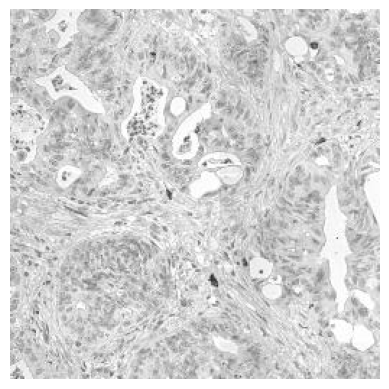

In [7]:
provider = DataSetProvider(config)

moving_images = provider.load_data_set(Stages.TESTING).original_data[48]
moving_images = np.array(Image.open(moving_images).convert("L"))
moving_images = moving_images / np.max(moving_images)

plot_img(moving_images)

moving_images = tf.convert_to_tensor(moving_images, dtype=tf.float32)
moving_images = tf.expand_dims(moving_images, axis=0)
moving_images = tf.expand_dims(moving_images, axis=-1)

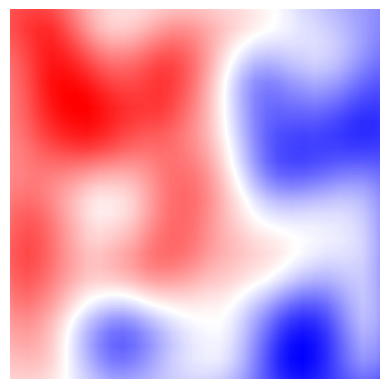

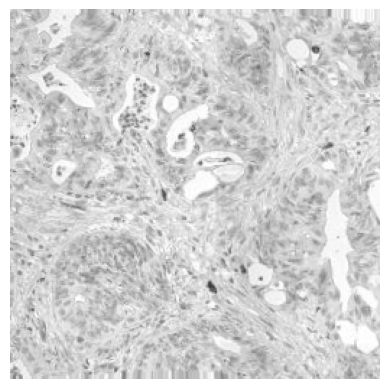

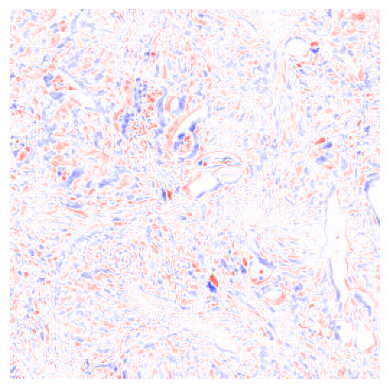

Property                  Value            
------------------------  -----------------
coefficient_of_variation  33415.01770019531
dissimilarity             22.022457        
maximum                   174.2303         
mean                      0.08863886       
minimum                   -186.17532       
size                      65536            
standard_deviation        29.618689        


In [34]:
gt_fields, poisoned_gt_fields = SyntheticFieldsProvider(config, Stages.TESTING).generate(
    ShapeBreakDown(moving_images)
)

gt_displacements = sample(gt_fields, config.displacements_control_points_spacings)

fixed_images, _ = warp_images(moving_images, poisoned_gt_fields)

plot_img_diff((gt_fields/tf.reduce_max(gt_fields))[0, ..., 0].numpy())
plot_img(fixed_images[0, ..., 0].numpy())
plot_img_diff((fixed_images - moving_images)[0, ..., 0].numpy())
print_object(calc_statistics((fixed_images - moving_images) * 255))

(3, 7, 1, 7, 7, 32)
(7, 7)


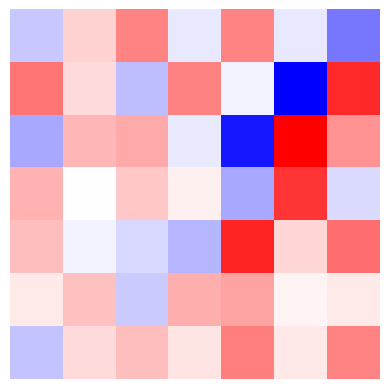

In [41]:
KERNELS_VARS_PATH = "output/E5a/saved_models/10/data_term_kernels.npy"

kernels = np.load(KERNELS_VARS_PATH)

print(kernels.shape)

pl_index = 2
vu_index = 6
kernel_index = 1

kernel = kernels[pl_index, vu_index, 0, ..., kernel_index]

print(kernel.shape)

heat_map_drawer(
    kernel,
    title="",
    display_grid=False,
    display_axis=False,
    title_font_size=None,
    color_map_name=config.displacements_preview_color_map,
    color_map_min_val=np.min(kernel),
    color_map_max_val=np.max(kernel),
)
plt.show()

kernel = tf.expand_dims(kernel, axis=-1)
kernel = tf.expand_dims(kernel, axis=-1)

tf.Tensor([  1 256 256   1], shape=(4,), dtype=int32)


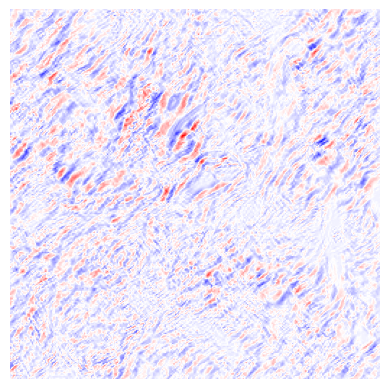

In [37]:
res = tf.nn.conv2d(fixed_images - moving_images, kernel, [1,1,1,1], 'SAME')

print(tf.shape(res))

# plot_img_diff(res[0,...,0].numpy())

heat_map_drawer(
    res[0,...,0].numpy(),
    title="",
    display_grid=False,
    display_axis=False,
    title_font_size=None,
    color_map_name=config.displacements_preview_color_map,
    color_map_min_val=tf.reduce_min(res).numpy(),
    color_map_max_val=tf.reduce_max(res).numpy(),
)
plt.show()